In [3]:
import pickle
train_mat_neg = pickle.load(open('/home/asaliao/SSLRec/datasets/multi_behavior/retail_rocket/train_mat_buy.pkl', 'rb'))
train_mat_neg

<2174x30113 sparse matrix of type '<class 'numpy.int64'>'
	with 9551 stored elements in Compressed Sparse Row format>

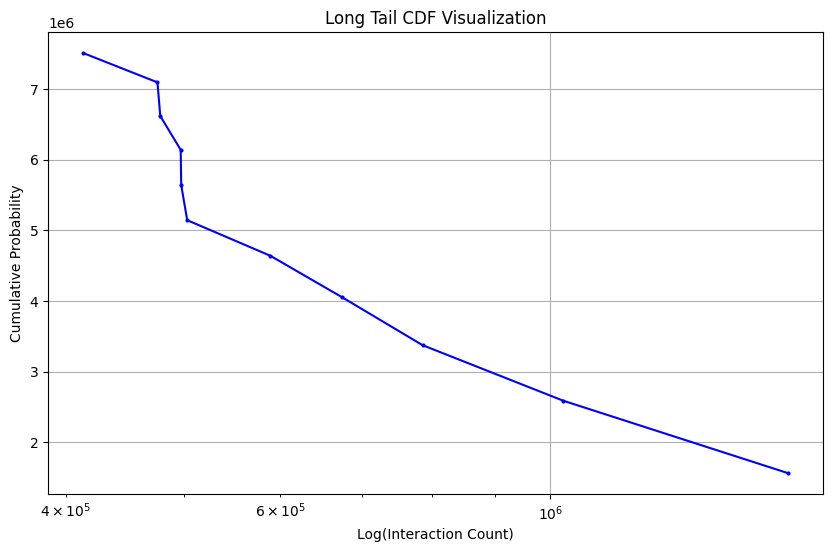

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# 假设df是包含你的数据的DataFrame
df = pd.read_csv("/home/asaliao/SSLRec/datasets/sequential/ml-20m_seq/train.tsv", sep='\t', header=0)#.astype('int')

# 创建一个包含所有item_id的列表
all_items = [item for sublist in df['item_id_seq'] for item in sublist]
all_items_set = set(all_items)

# 计算每个item_id的交互次数
interaction_counts = [all_items.count(item) for item in all_items_set]

# 将交互次数进行排序
sorted_interaction_counts = sorted(interaction_counts, reverse=True)

# 计算累积分布函数（CDF）
cdf = [sum(sorted_interaction_counts[:i + 1]) for i in range(len(sorted_interaction_counts))]

# 绘制CDF图
plt.figure(figsize=(10, 6))
plt.plot(sorted_interaction_counts, cdf, color='blue', marker='o', linestyle='-', markersize=2)
plt.xscale('log')  # 使用对数尺度，更好地展示长尾
plt.xlabel('Log(Interaction Count)')#对数尺度每个点表示在数据集中有至少这么多次交互的item的数量。横坐标为2，表示有至少10^2=100次交互的item的数量
plt.ylabel('Cumulative Probability')#累积概率，即有至少这么多次交互的item占总item数量的比例。纵坐标为0.8，表示有至少这么多次交互的item占总item数量的80%。
plt.title('Long Tail CDF Visualization')
plt.grid(True)
plt.show()
'''长尾的程度： 长尾分布的尾部有多长 即在图的右侧有多少item。这可以通过观察图的尾部来判断。

前百分之多少的item贡献了多少的交互  可以通过查看图的横坐标在某个值 例如 横坐标为2 时的纵坐标值来了解。横坐标为2时 纵坐标为0.8 表示前百分之80的item贡献了至少100次的交互。

是否存在冷启动： CDF图的起始部分表示交互次数较少的item。如果起始部分有很多item 则存在冷启动问题'''


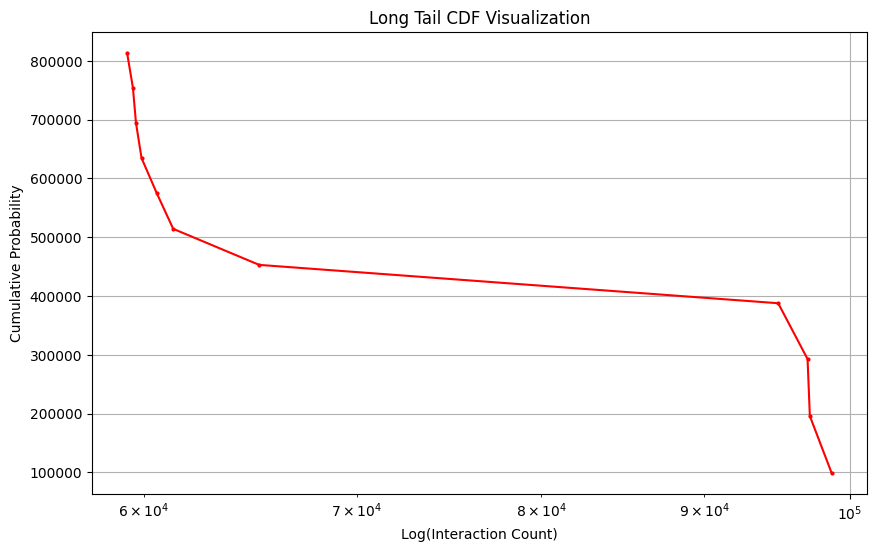

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

df2 = pd.read_csv("/home/asaliao/SSLRec/datasets/sequential/beauty_seq/train.tsv", sep='\t', header=0)#.astype('int')


all_items = [item for sublist in df2['item_id_list:token_seq'] for item in sublist]
all_items_set = set(all_items)

# 计算每个item_id的交互次数
interaction_counts = [all_items.count(item) for item in all_items_set]

# 将交互次数进行排序
sorted_interaction_counts = sorted(interaction_counts, reverse=True)

# 计算累积分布函数（CDF）
cdf = [sum(sorted_interaction_counts[:i + 1]) for i in range(len(sorted_interaction_counts))]

# 绘制CDF图
plt.figure(figsize=(10, 6))
plt.plot(sorted_interaction_counts, cdf, color='red', marker='o', linestyle='-', markersize=2)
plt.xscale('log')  # 使用对数尺度，更好地展示长尾
plt.xlabel('Log(Interaction Count)')#对数尺度每个点表示在数据集中有至少这么多次交互的item的数量。横坐标为2，表示有至少10^2=100次交互的item的数量
plt.ylabel('Cumulative Probability')#累积概率，即有至少这么多次交互的item占总item数量的比例。纵坐标为0.8，表示有至少这么多次交互的item占总item数量的80%。
plt.title('Long Tail CDF Visualization')
plt.grid(True)
plt.show()


In [2]:
import torch
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self, item_count, embedding_size, output_size, n1):
        super(CustomModel, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(item_count, embedding_size)

        # Learnable global matrix A_i
        self.A_i = nn.Parameter(torch.randn(item_count, item_count))

        # Learnable matrix A_N with prior
        self.A_N = nn.Parameter(torch.randn(item_count, item_count))

        # Apply prior to A_N (set diagonal elements to 0)
        self.A_N.data = self.apply_prior(self.A_N.data, item_count)
        print(self.A_N)

        # Linear layer
        self.linear = nn.Linear(embedding_size, output_size)

    def apply_prior(self, matrix, item_count):
        # Set diagonal elements to 0
        matrix[torch.arange(item_count), torch.arange(item_count)] = 0
        return matrix

    def forward(self, input_sequence):
        # Embedding
        embedded_sequence = self.embedding(input_sequence)

        # Take the corresponding part of A_i based on the items in the sequence
        A_i_batched = self.A_i.index_select(0, input_sequence.view(-1)).view(input_sequence.size(0), input_sequence.size(1), -1)

        # Multiply A_i with embedded_sequence
        latent_representation = torch.bmm(A_i_batched, embedded_sequence)

        # Learnable matrix A_K with prior
        A_K = 0.5 * ((A_i_batched + self.A_N) + (A_i_batched + self.A_N).t())

        # Linear layer
        output = self.linear(latent_representation)

        return output

# Example usage
item_count = 1000  # Example item count
embedding_size = 64  # Example embedding size
output_size = 10  # Example output size
n1 = 0.5  # Example prior value for diagonal elements

# Create model
model = CustomModel(item_count, embedding_size, output_size, n1)

# Example input sequence
input_sequence = torch.randint(0, item_count, (512, 50))  # Batch size of 512, sequence length of 50

# Forward pass
output = model(input_sequence)

# Print the output size
print(output.size())


Parameter containing:
tensor([[ 0.0000e+00, -5.8309e-01, -9.9668e-01,  ...,  6.1946e-01,
         -4.4380e-04,  5.2486e-01],
        [-4.9554e-01,  0.0000e+00,  6.4334e-01,  ...,  9.4774e-01,
          2.8189e-01, -1.2976e+00],
        [-3.8361e-03,  9.1032e-01,  0.0000e+00,  ..., -8.7359e-01,
          7.7236e-01, -1.2318e+00],
        ...,
        [ 1.7496e-01,  6.6068e-01,  5.5226e-01,  ...,  0.0000e+00,
          3.6369e-01, -3.3428e-01],
        [-3.2777e-01,  1.7754e+00, -8.8207e-03,  ..., -1.0762e+00,
          0.0000e+00,  8.3566e-01],
        [ 6.2144e-01, -1.7399e+00, -2.0290e-01,  ..., -1.4851e+00,
          1.3125e+00,  0.0000e+00]], requires_grad=True)


RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [512, 1000] but got: [512, 50].